Compare different inter-cluster distances

exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
ward


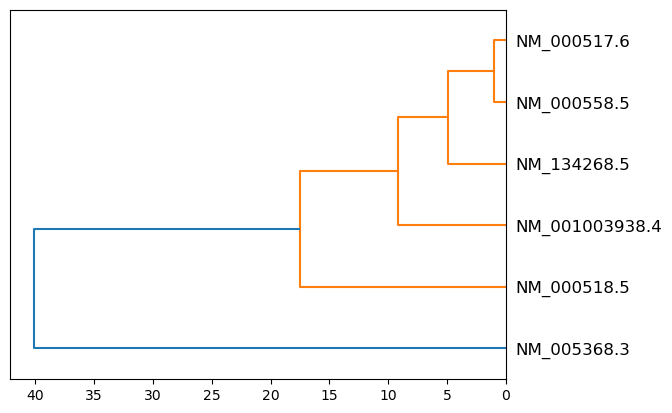

single


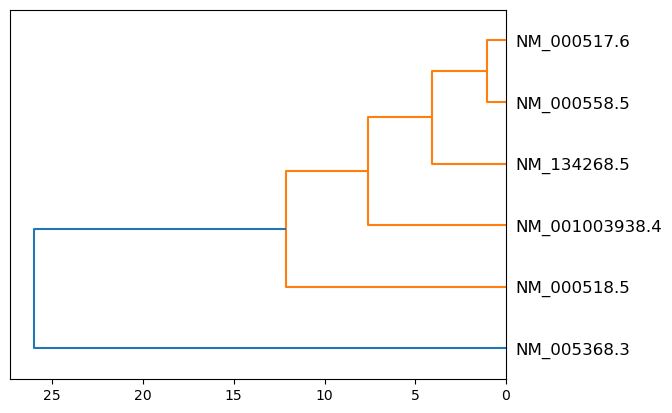

complete


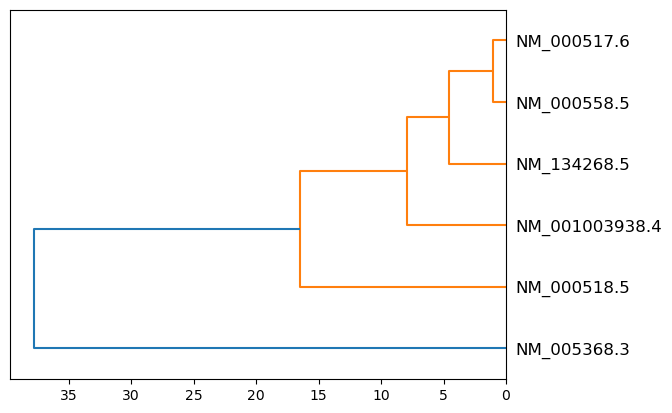

centroid


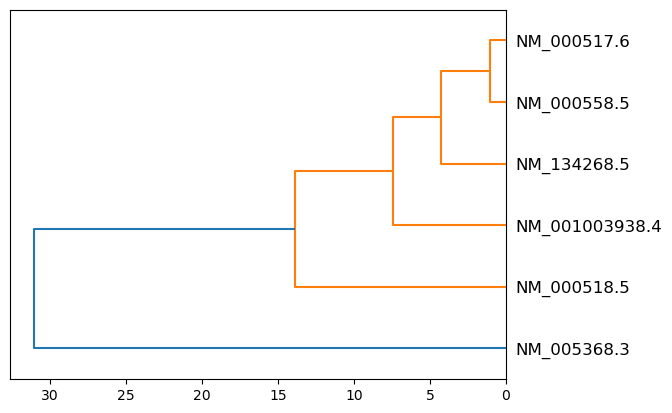

median


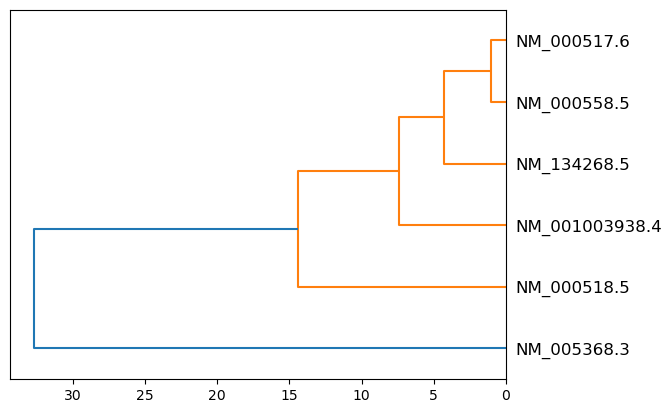

weighted


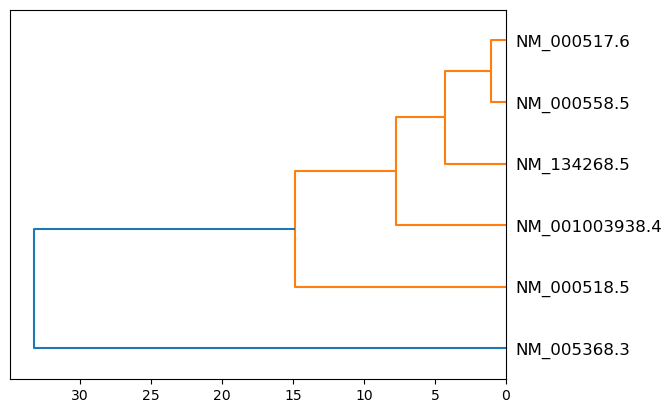

average


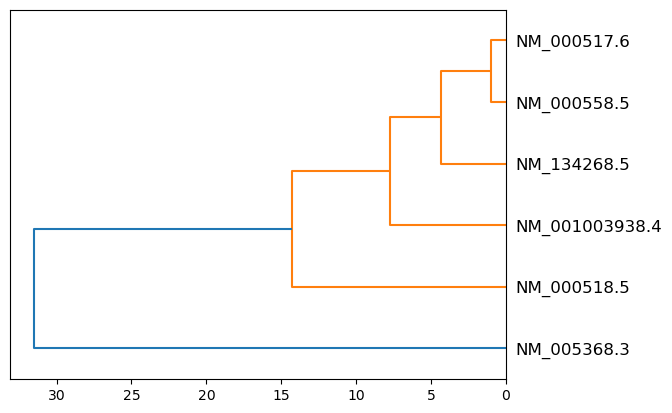

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist
import utils
from IPython.core.interactiveshell import InteractiveShell
import matplotlib.pyplot as plt
from autoembedding.embeddings_matrix import build_embeddings_matrix
#InteractiveShell.ast_node_interactivity = "all"

#PATH = "dataset/NEIS2157.json"
PATH = "dataset/globins/globins.json"

embeddings_dict = utils.get_embeddings_dict(PATH)

IDs, embeddings_matrix = build_embeddings_matrix(
    embeddings_dict = embeddings_dict,
    embedder="prose",
    combiner_method="average"
)

methods = ["ward", "single", "complete", "centroid", "median", "weighted", "average"]

condensed_distances = pdist(embeddings_matrix)

for method in methods:
    print(method)
    # Perform hierarchical clustering
    Z = linkage(condensed_distances, method=method)
    # Plot dendrogram
    dendrogram(Z, orientation="left", labels=IDs)

    plt.show()

# Get cluster labels
#max_d =30  # set the maximum distance between clusters
#labels = fcluster(Z, max_d, criterion='distance')
#print(labels)

Compare different embeddings with scaling and pca

INFO  : Finished optimising at entanglement 0.06 (tanglegram.tangle)
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
exception in get ordered ids
exception in get ordered ids


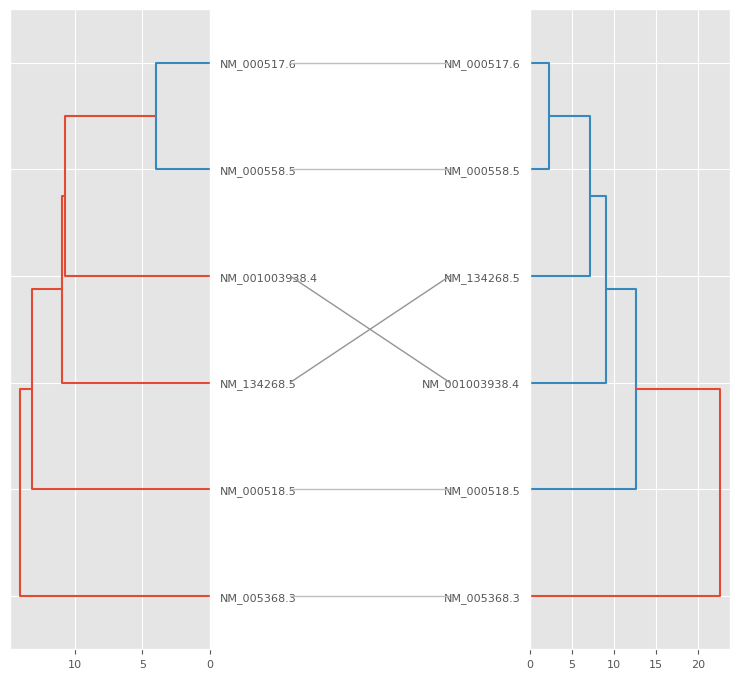

In [5]:
import tanglegram as tg
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Loading the embeddings dict
embeddings_dict = utils.get_embeddings_dict(PATH)

# Building the embedding matix
IDs, embeddings_matrix_A = build_embeddings_matrix(
    embeddings_dict = embeddings_dict,
    embedder="rep",
    combiner_method="none"
)

IDs, embeddings_matrix_B = build_embeddings_matrix(
    embeddings_dict = embeddings_dict,
    embedder="prose",
    combiner_method="max"
)

# Scaling
scaler = StandardScaler()
embeddings_matrix_A = scaler.fit_transform(embeddings_matrix_A)
scaler = StandardScaler()
embeddings_matrix_B = scaler.fit_transform(embeddings_matrix_B)


# Principal component analysis
pca = PCA(n_components=5)
embeddings_matrix_A = pca.fit_transform(embeddings_matrix_A)
pca = PCA(n_components=5)
embeddings_matrix_B = pca.fit_transform(embeddings_matrix_B)


# Buliding an array encoding the pairwise distances between rows (observations) in the embedding matrix
condensed_distances_A = pdist(embeddings_matrix_A, metric="euclidean")
condensed_distances_B = pdist(embeddings_matrix_B, metric="euclidean")


# Calculating the hierarchical clustering 
linkage_matrix_A = linkage(condensed_distances_A, method="average")
linkage_matrix_B = linkage(condensed_distances_B, method="average")
                   

# Plot tanglegram   
fig = tg.plot(
    linkage_matrix_A, 
    linkage_matrix_B,
    labelsA=IDs,
    labelsB=IDs,
    sort="step2side", 
    link_kwargs = {},
    dend_kwargs={}
)

plt.show()

Phylogenetic tree with clustalw2

In [12]:
from Bio.Align.Applications import ClustalwCommandline
from Bio import Phylo

cmd =  ClustalwCommandline("clustalw2", infile="dataset/NEIS2157.fasta", outfile="dataset/NEIS2157_aligned.aln")
#stdout, stderr = cmd()
tree = Phylo.read("dataset/NEIS2157.dnd", format="newick")



In [10]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import squareform

def newick_to_linkage(tree , label_order = None):
    """
    Convert newick tree into scipy linkage matrix

    :param newick: newick string, e.g. '(A:0.1,B:0.2,(C:0.3,D:0.4):0.5);'
    :param label_order: list of labels, e.g. ['A', 'B', 'C']
    :returns: linkage matrix and list of labels
    """
    # newick string -> cophenetic_matrix
    
    cophenetic_matrix, newick_labels = tree.cophenetic_matrix()
    cophenetic_matrix = pd.DataFrame(cophenetic_matrix, columns=newick_labels, index=newick_labels)

    if label_order is not None:
        # sanity checks
        missing_labels = set(label_order).difference(set(newick_labels))
        superfluous_labels = set(newick_labels).difference(set(label_order))
        assert len(missing_labels) == 0, f'Some labels are not in the newick string: {missing_labels}'
        if len(superfluous_labels) > 0:
            print(f'Newick string contains unused labels: {superfluous_labels}')

        # reorder the cophenetic_matrix
        cophenetic_matrix = cophenetic_matrix.reindex(index=label_order, columns=label_order)

    # reduce square distance matrix to condensed distance matrices
    pairwise_distances = squareform(cophenetic_matrix)

    # return linkage matrix and labels
    return linkage(pairwise_distances), list(cophenetic_matrix.columns)


newick_to_linkage(tree=tree, label_order=)

In [15]:
from Bio import Phylo
import numpy as np
import io

def newick_string_to_linkage_matrix(newick_str):
    
    # create tree object via Biopython (Bio.Phylo)
    tree = next(Phylo.parse(io.StringIO(newick_str), format="newick"))
    # calculate tree height
    tree_height = max(tree.distance(c) for c in tree.find_clades(terminal=True))
    # add comment with id and span of terminal nodes:
    id_map = {}
    for i, c in enumerate(tree.find_clades(terminal=True)):
        c.comment = (i, 1) 
        id_map = {i: c.name}
    # ancestor list orderred by distance from the root
    anc_lst = []
    for c in tree.find_clades(terminal=False):
        d = tree.distance(c)
        anc_lst.append((c, list(c), d))
    anc_lst.sort(key=lambda x:x[2], reverse=True)
    # running number of node
    nodes = len(list(tree.find_clades(terminal=True)))
    lnk_lst = []
    for anc,children, anc_d in anc_lst:
        n_children = len(children)
        assert n_children>=2
        child1 = children[0]
        for child2 in children[1:]:
            id1, n_leaves1 = child1.comment
            id2, n_leaves2 = child2.comment
            total_leaves = n_leaves1 + n_leaves2
            anc.comment = (nodes, total_leaves)
            distance = tree_height - anc_d
            nodes += 1
            row = [id1, id2, distance, total_leaves]
            lnk_lst.append(row)
            child1 = anc
    return np.array(lnk_lst), id_map

newick_string_to_linkage_matrix(print(tree))


Tree(rooted=False, weight=1.0)
    Clade()
        Clade(branch_length=0.0)
            Clade(branch_length=0.0)
                Clade(branch_length=0.0)
                    Clade(branch_length=0.0)
                        Clade(branch_length=0.0)
                            Clade(branch_length=0.0, name='NEIS2157_1')
                            Clade(branch_length=0.00089, name='NEIS2157_17')
                        Clade(branch_length=0.00089, name='NEIS2157_18')
                    Clade(branch_length=0.00089, name='NEIS2157_19')
                Clade(branch_length=0.00089, name='NEIS2157_20')
            Clade(branch_length=0.00089, name='NEIS2157_22')
        Clade(branch_length=0.0)
            Clade(branch_length=0.0)
                Clade(branch_length=0.0)
                    Clade(branch_length=0.0)
                        Clade(branch_length=0.0)
                            Clade(branch_length=0.0)
                                Clade(branch_length=0.0)
                    

StopIteration: 